**Лабораторный практикум по курсу «Распознавание диктора», Университет ИТМО, 2021**		

**Лабораторная работа №1. Информативные признаки речевых сигналов: извлечение признаков**

**Цель работы:** изучение процедуры построения информативных акустических признаков для речевых сигналов.

**Содержание лабораторной работы**

1. Выполнить процедуру высокочастотной фильтрации (преэмфазис) речевого сигнала.

2. Вычислить акустические признаки разных видов.

3. Выполнить локальные центрирование и масштабирование акустических признаков.

4. Построить распределение первых 3 компонент полученных акустических признаков для мужских и женских голосов.

In [23]:
# Import of modules
import os
import sys

sys.path.append(os.path.realpath('..'))

from common import download_dataset, extract_dataset

from math import sqrt, pi

import numpy as np
import matplotlib.pyplot as plt

from skimage.morphology import opening, closing
from torchaudio.transforms import Resample
from multiprocessing import Pool
import torchaudio

**1. Подготовка данных для обучения и тестирования детектора речевой активности**

В ходе выполнения лабораторной работы необходимы данные для осуществления процедуры вычисления акустических признаков. Возьмём в качестве этих данных несколько звукозаписей голосов людей мужского и женского пола, сохраненных в формат *wav*, выбранных из корпуса [VoxCeleb1 test set](https://thor.robots.ox.ac.uk/~vgg/data/voxceleb/vox1a/vox1_test_wav.zip). Данный корпус содержит 4,874 звукозаписи (частота дискретизации равна 16кГц) 40 дикторов мужского и женского пола, разговаривающих на английском языке.

В рамках настоящего пункта требуется выполнить загрузку и распаковку звуковых wav-файлов из корпуса VoxCeleb1 test set.

![Рисунок 1](https://analyticsindiamag.com/wp-content/uploads/2020/12/image.png "VoxCeleb. Крупномасштабная аудиовизуальная база данных человеческой речи.")

In [4]:
# Download VoxCeleb1 (test set)
with open('../data/lists/datasets.txt', 'r') as f:
    lines = f.readlines()

download_dataset(lines, user='voxceleb1902', password='nx0bl2v2', save_path='../data')

Checksum successful vox1_test_wav.zip.
https://thor.robots.ox.ac.uk/~vgg/data/voxceleb/vox1a/vox1_test_wav.zip 185fdc63c3c739954633d50379a3d102



In [14]:
# Extract VoxCeleb1 test set
extract_dataset(save_path='../data/voxceleb1_test', fname='../data/vox1_test_wav.zip')

Extracting of ../data/vox1_test_wav.zip is successful.


**2. Выполнить процедуру загрузки речевого сигнала. Осцилограмма. Спектрограмма.**

Для начала давайте загрузим пример речевого сигнала в память компьютера. Сейчас существует достаточно много библиотек для работы со звуковыми файлами (scipy.io.wavfile, soundfile, torchaudio и др). Можно использовать любую из них для работы со звуковыми файлами. Мы остановим свой выбор на torchaudio для удобства и системности дальнейшего изложения. В папке .\metadata представлен файл meta.txt со списком файлов, которые мы предлагаем использовать в данной лабораторной работе.  он имеет достаточно простой формат строк: 

> Speaker_ID Gender Path

> id10271 m ../data/voxceleb1_test/wav/id10271/1gtz-CUIygI/00006.wav

>...

Распарсим файл с метаинформацией и загрузим первый по списку файл.  


In [16]:
# let's prepare split_meta_line function for meta line parsing
def split_meta_line(line, delimiter=' '):
    spt_res = line.split(delimiter)
    speaker_id = spt_res[0]
    gender = spt_res[1]
    file_path = spt_res[2].strip()

    return speaker_id, gender, file_path


path_to_meta = "./metadata/meta.txt"
p = Pool(1)
with open(path_to_meta, 'r') as f:
     list_lines = f.readlines()
speaker_ids, genders, paths = zip(*p.map(split_meta_line, list_lines[1:]))

path_to_wav = paths[0]

In [20]:
print("Loading of {}".format(path_to_wav))
# Load signal
signal, fs = torchaudio.load(path_to_wav)
signal = signal.numpy().squeeze(axis=0)
signal = signal/np.abs(signal).max()
print("Done!")

Loading of ../data/voxceleb1_test/wav/id10271/1gtz-CUIygI/00006.wav
Done!


Нарисуем осцилограмму и спектрограмму первых 3.5 секунд речевого сигнала:

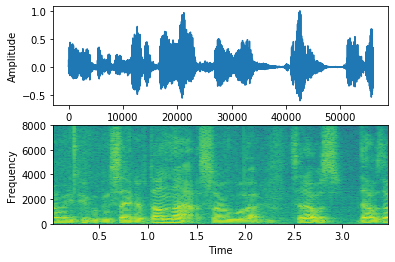

In [27]:
signal = signal[0:int(3.5 * fs)]  # Keep the first 3.5 seconds

plt.figure(1)
plot_a = plt.subplot(211)
plt.subplots_adjust(wspace=0, hspace=1)

plot_a.plot(signal)
plot_a.set_xlabel('sample rate * time')
plot_a.set_ylabel('Amplitude')

plot_b = plt.subplot(212)
plot_b.specgram(signal, NFFT=1024, Fs=fs, noverlap=900)
plot_b.set_xlabel('Time')
plot_b.set_ylabel('Frequency')
plt.show()

**2. Выполнить процедуру высокочастотной фильтрации (преэмфазис) речевого сигнала**

Можно добавить краткую теорию про преэмфазис. Краткое описание того, что нужно сделать.

In [28]:
pre_emphasis = 0.97
emphasized_signal = np.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])

Нарисуем спектрограммы обработанного и сырого сигналов

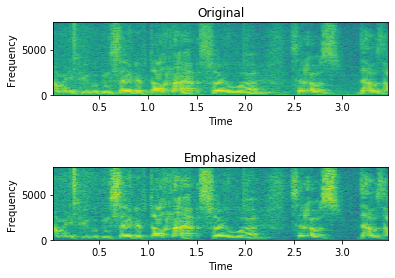

In [34]:
plt.figure(2)
plot_a = plt.subplot(211)
plt.subplots_adjust(wspace=0, hspace=1)

plot_a.specgram(signal, NFFT=1024, Fs=fs, noverlap=900)
plot_a.set_xlabel('Time')
plot_a.set_ylabel('Frequency')
plot_a.title.set_text('Original')

plot_b = plt.subplot(212)
plot_b.specgram(emphasized_signal, NFFT=1024, Fs=fs, noverlap=900)
plot_b.set_xlabel('Time')
plot_b.set_ylabel('Frequency')
plot_b.title.set_text('Emphasized')

plt.show()

**3. Вычислить акустические признаки разных видов**

Можно добавить краткую теорию про вычисление логарифмов энергий на выходе мел-банка фильтров размерности 40 и мел-частотные кепстральные коэффициенты размерности 23. Краткое описание того, что нужно сделать.

**4. Выполнить локальные центрирование и масштабирование акустических признаков**

Можно добавить краткую теорию про выполнения процедур нормализации и масштабирования. Краткое описание того, что нужно сделать.

**5. Построить распределение первых 3 компонент полученных акустических признаков для мужских и женских голосов**

Краткое описание того, что нужно сделать.

**6. Контрольные вопросы**

1. Какие способы представления сигналов существуют?

2. Что такое спектр Фурье (амплитудный и фазовый)?

3. Что такое оконное преобразование Фурье?

4. Что такое спектрограмма?

5. Как выполнить процедуру преэмфазиса?

6. Описать процедуру вычисления акустических признаков.

7. Для каких целей выполняются процедуры нормализации и масштабирования акустических признаков?

**7. Список литературы**

1. Hayes M.H. Schaum’s outlines of digital signal processing. McGraw-Hill, 2011 ([ссылка](http://index-of.co.uk/DSP-Collection/Hayes,%20M.H.,%20Schaum's%20Outline%20of%20Digital%20Signal%20Processing,%20McGraw-Hill,%201999.pdf)).

2. Beigi H. Fundamentals of speaker recogniton. Springer, 2011 ([ссылка](https://www.springer.com/gp/book/9780387775913)).

### Лабораторная работа №1. Информативные признаки речевых сигналов: извлечение признаков
**Описание**:
В рамках данной лабораторной работы вам предстоит познакомиться с процедурами предобработки речевых сигналов и извлечения информативных признаков. В данной работе вам предлагается научиться извлекать

- Mel Filter Banks - кратковременные энергии мелчастотных полос
- Mel Frequency Cepstral Coeffitients - Мел частотные кепстральные коэффициенты

Признаки должны совпадать с соответствующими признаками, которые извлекаются в **torchaudio** (https://pytorch.org/audio/stable/transforms.html)

**Данные**:
В качестве данных для проведения исследования предлагается взять базу VoxCeleb1: http://www.robots.ox.ac.uk/~vgg/data/voxceleb/vox1.html.

**Задания**:
1. Сделать preemphasis (фильтрация верхних частот). Проанализировать амлитудно-частотные спектры исходного и обработанного речевых участков сигналов
2. Вычислить акустические признаки разных видов: FBs40 и MFCCs23.
3. Выполнить локальное центрирование и масштабирование признаков (нормализация MVN).
4. Построить распределение первых 3 компонент полученных признаков по всей базе отдельно по гендерам

### 1. Preemphasis preprocessing

In [2]:
from audiofeatures import Audiofeatures
processed_waveform = Audiofeatures.preemphasis(waveform)

NameError: name 'waveform' is not defined

### 2. Mel Filter Banks computing

In [3]:
MFB40_FeaturesExctractor = Audiofeatures(feats_type='MFB40')
MFB40 = MFB40_FeaturesExctractor.extract('wav_path')

NotImplementedError: 

### 3. Mel Frequency Cepstral Coeffitiens computing

In [ ]:
MFCC_FeaturesExctractor = Audiofeatures(feats_type='MFCC')
MFCC = MFCC_FeaturesExctractor.extract('wav_path')